# Point based value iteration for POMDPs

This post is intended for audiance who are already familiar with tabular solutions of Markov Decision Processes (MDP) and has some knowledge about Partially Observable Markov Decision Processes (POMDP). We will be discussing an approximate method for solving POMDPs called [Point Based Value Iteration (PBVI)](http://www.cs.cmu.edu/~ggordon/jpineau-ggordon-thrun.ijcai03.pdf). 

In POMDPs, we are no longer able to observe the state of the envionment $s$ but an observation generated from distribution $P(o|s, a)$ at each time step. The transition matrix and reward function are defined the same way as in an MDP as $P(s'|s, a)$ and $R(s, a)$, respectively. We assume these probabilities and the reward function are given and our goal is to compute the optimal value function and the corresponding policy. 

The main challenge of solving a POMDP is representing the value function, which is usually defined as a function of either the entire interation history or the agent's belief about the environment state, both of which are complex objects. PBVI belongs to the latter class of representing the value function as a function of beliefs. It intuitively uses sampled points to represent the continuous belief space. However, most papers and tutorials online are unintuitive and there exists few python implementations. Some of the more useful tutorials I found were this [review paper](https://www.bgu.ac.il/~shanigu/Publications/PointBasedSurvey.pdf) and this [lecture note](https://cs.uwaterloo.ca/~ppoupart/teaching/cs886-spring13/slides/cs886-module14-intro-POMDPs.pdf). My hope is to provide a relatively clear tutorial and implementation with a simple and classic POMDP problem.

## PBVI unpacked
**The mysterious alpha vectors.** In my opinion, the main conceptual hurdle is that of representing the value function using a set of $N$ so-called alpha vectors $\{\alpha_1, ..., \alpha_N\}$, which is very different from representing the value function as a lookup table as in MDPs. We will not dewell on how the number $N$ is chosen. Each alpha vector is a vector with length equal to the number of states $|\mathcal{S}|$ and we denote each element in an alpha vector with $\alpha_{i}(s)$. The (optimal) value function is defined as the maximum of the dot products between the queried belief vector $b(s)$ and every alpha vector $\alpha_{i}(s)$:
\begin{align}
V(b) = \max_{\alpha_{i}} \sum_{s}b(s)\alpha_{i}(s) = \max_{\alpha_{i}}b\cdot\alpha_{i}
\end{align}
where "$\cdot$" denotes vector dot product.

Note that the max has to be found for each belief. Imaging you have stored a ton of alpha vectors, each time you get queried for the value of a belief, you simply compute its dot product with all alpha vectors you have stored and select the one with the highest dot product value.

**Value iteration in the space of alpha vectors.** The next conceptual challenge following the representation of value with alpha vectors is how to update the alpha vectors using a procedure similar to value iteration in MDPs? Let's first write out the POMDP value function defined in terms of beliefs:
\begin{align}
V(b) = \max_{a}R(b, a) + \gamma \sum_{o'}P(o'|b, a)V(b')
\end{align}
where the max is taken w.r.t. to action $a$ and $\gamma$ is the discount factor. 

Here, the belief reward is defined as:
\begin{align}
R(b, a) = \sum_{s}b(s)R(s, a) = b\cdot R(s, a)
\end{align}

The compound transition matrix is defined as:
\begin{align}
\begin{split}
P(o'|b, a) &= \sum_{s'}\sum_{s}P(o'|s', a)P(s'|s, a)b(s) \\
&= \sum_{s}\tilde{P}(o'|s, a)b(s) \\
&= b \cdot \tilde{P}(o'|s, a)
\end{split}
\end{align}
where we have defined a new distribution $\tilde{P}(o'|s, a) = \sum_{s'}P(o'|s', a)P(s'|s, a)$.

The next belief $b'$ is the belief one would have obtained if one observes $o'$ in the next time step. The belief is updated as:
\begin{align}
b'(s) = \frac{\sum_{s}P(o'|s', a)P(s'|s, a)b(s)}{\sum_{s'}\sum_{s}P(o'|s', a)P(s'|s, a)b(s)}
\end{align}

In **PBVI**, we perform the value function update only on a set of $M$ sampled belief points $\{b_1, ..., b_{M}\}$. We then define as many alpha vectors as the number of belief points we have. 

Now, the **key trick** is to write the value function in terms of the alpha vectors and dot products with beliefs where possible:
\begin{align}
\begin{split}
b \cdot \alpha_i &= \max_{a}b \cdot R(s, a) + \gamma \sum_{o'}b \cdot \tilde{P}(o'|s, a)\max_{\alpha_{j}'}b'\cdot\alpha_{j}' \\
\end{split}
\end{align}
Let $a^{*}$ denote the action achieving the maximum in the equation above, the alpha vectors are updated as:
\begin{align}
\alpha_i &= R(s, a^{*}) + \gamma \sum_{o'}\tilde{P}(o'|s, a^{*})\max_{\alpha_{j}'}b'\cdot\alpha_{j}'
\end{align}
You can check the updated alpha vectors have length equal to the number of states $|\mathcal{S}|$.

We will do some imports and set the plotting style and then start our example problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as torch_dist

In [2]:
seed = 0

# set plotting style
strip_size = 10
label_size = 12
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size

## The classic Tiger problem
In the classic tiger problem, we have two closed doors. There is a tiger that could be behind either the left or the right door. The goal of the decision maker is to open the door where there is no tiger for multiple rounds of play. At each round, the decision maker has three choices: 1) open the left door, 2) open the right door, 3) listen. The decision maker gets a reward of $10$ if opened the no-tiger door, $-100$ if opened the tiger door, and $-1$ for listening. If the decision maker opens the left (or right) door, the tiger will be moved to the other door with probability $(1-p)$ (or $1-q$). However, if the decision maker listens, it will hear a roar from either the left door (with probability $a$ if the tiger is behind the left door) or the right door (with probability $b$ if the tiger is behind the right door), and the position of the tiger will not change. The state, action, and observation spaces and the transition, observation, and reward matrices are listed below.

$\mathcal{S} = \{S_0=\textit{tiger left}, S_1=\textit{tiger right}\}$

$\mathcal{A} = \{A_0=\textit{listen}, A_1=\textit{open left}, A_2=\textit{open right}\}$

$\mathcal{O} = \{O_o=\textit{hear left}, O_1=\textit{hear right}\}$

Transition probabilities: $P(s'|s, a)$
\begin{array}{ccc}
Prob. (A_0=\textit{listen}) & S_0=\textit{tiger left} & S_1=\textit{tiger right} \\
\hline
S_0=\textit{tiger left} & 1 & 0 \\
S_1=\textit{tiger right} & 0 & 1
\end{array}

\begin{array}{ccc}
Prob. (A_1=\textit{open left}) & S_0=\textit{tiger left} & S_1=\textit{tiger right} \\
\hline
S_0=\textit{tiger left} & p & 1-p \\
S_1=\textit{tiger right} & 1-q & q
\end{array}

\begin{array}{ccc}
Prob. (A_2=\textit{open right}) & S_0=\textit{tiger left} & S_1=\textit{tiger right} \\
\hline
S_0=\textit{tiger left} & q & 1-q \\
S_1=\textit{tiger right} & q-p & p
\end{array}

Observation probabilities: $P(o|s, a)$
\begin{array}{ccc}
Prob. (A_0=\textit{listen}) & O_0=\textit{hear left} & O_1=\textit{hear right} \\
\hline
S_0=\textit{tiger left} & a & 1-a \\
S_1=\textit{tiger right} & 1-b & b
\end{array}

\begin{array}{ccc}
Prob. (A_1=\textit{open left}) & O_0=\textit{hear left} & O_1=\textit{hear right} \\
\hline
S_0=\textit{tiger left} & 1 & 0 \\
S_1=\textit{tiger right} & 0 & 1
\end{array}

\begin{array}{ccc}
Prob. (A_2=\textit{open right}) & O_0=\textit{hear left} & O_1=\textit{hear right} \\
\hline
S_0=\textit{tiger left} & 1 & 0 \\
S_1=\textit{tiger right} & 0 & 1
\end{array}

Reward function: $R(s, a)$
\begin{array}{cccc}
Reward & A_0=\textit{listen} & A_1=\textit{open left} & A_2=\textit{open right} \\
\hline
S_0=\textit{tiger left} & -1 & 10 & -100 \\
S_1=\textit{tiger right} & -1 & -100 & 10
\end{array}

We will implement the tiger problem as a class below.

In [31]:
class TigerEnv():
    def __init__(self, p, q, a, b, num_grids):
        self.state_dim = 2
        self.obs_dim = 2
        self.act_dim = 3

        self.state_labels = ["tiger left", "tiger_right"]
        self.obs_labels = ["hear left", "hear right"]
        self.act_labels = ["listen", "open left", "open right"]

        self.transition_matrix = [[], [], []]
        self.transition_matrix[0] = [[1, 0], [0, 1]]
        self.transition_matrix[1] = [[p, 1-p], [1-q, q]]
        self.transition_matrix[2] = [[q, 1-q], [1-p, p]]
        self.transition_matrix = torch.Tensor(self.transition_matrix)

        self.observation_matrix = [[], [], []]
        self.observation_matrix[0] = [[a, 1-a], [1-b, b]]
        self.observation_matrix[1] = [[1, 0], [0, 1]]
        self.observation_matrix[2] = [[1, 0], [0, 1]]
        self.observation_matrix = torch.Tensor(self.observation_matrix)

        self.reward_matrix = [[-1, 10, -100], [-1, -100, 10]]
        self.reward_matrix = torch.Tensor(self.reward_matrix)
        
        eps = 1e-6
        self.num_grids = num_grids
        self.belief_grid = torch.linspace(eps, 1-eps, num_grids)
        self.belief_transition_matrix = self.compute_belief_transition_matrix(self.belief_grid)


    def compute_belief_transition_matrix(self, belief_grid):
        state_dim = len(belief_grid)
        state_id = torch.arange(state_dim)
        b = torch.stack([belief_grid, 1 - belief_grid]).T

        belief_transition_matrix = torch.zeros(self.act_dim, state_dim, state_dim)
        for a in range(self.act_dim):
            # compute observation predictive
            s_next = torch.einsum("ni, ij -> nj", b, self.transition_matrix[a])
            so_next = torch.einsum("nj, jo -> njo", s_next, self.observation_matrix[a])
            o_next = so_next.sum(-2)

            for o in range(self.obs_dim):
                # compute posterior
                b_next = so_next[:, :, o] / o_next[:, o].unsqueeze(-1)
                
                b_next_id = self.belief2grid(b_next)
                belief_transition_matrix[a, state_id, b_next_id] += o_next[:, o]
        return belief_transition_matrix

    def belief2grid(self, beliefs):
        """ Assign a belief vector to a grid based on l2 distance """
        b = torch.stack([self.belief_grid, 1 - self.belief_grid]).T
        d_func = lambda x: torch.pow(b - x.view(1, -1), 2).sum(1)
        grid_id = torch.Tensor([torch.argmin(d_func(x)) for x in beliefs]).long()
        return grid_id

In [32]:
# init env
P = 0.8 # left
Q = 0.8 # right
A = 0.85 # left
B = 0.85 # right
num_grids = 100 # number of intervals to divide the belief space
tiger_env = TigerEnv(P, Q, A, B, num_grids)

## Baseline solution
We will compare PBVI with a grid based solution method where we discretize the belief space into $N$ equally spaced intervals and treat each interval as a state in a MDP. This method can compute the value function accurately if the grid is fine enough. The computation of the **belief transition matrix** is already implemented as a part of the ```TigerEnv``` class. With this method, we can directly compute the value function using the second equation in the notebook. We will call this method grid value iteration.

In [5]:
class GridVI:
    """ Grid value iteration """
    def __init__(self, env, gamma):
        self.env = env
        self.gamma = gamma

        self.transition = env.transition_matrix
        self.observation = env.observation_matrix
        self.reward = env.reward_matrix
        self.belief_grid = env.belief_grid
        self.belief_transition = env.belief_transition_matrix

    def plan(self, max_iter=1000):
        """ Compute values for each horizon starting with zero value 
        
        Returns:
            v (torch.tensor): value for each horizon. size[H, num_grid]
        """
        state_dim = self.belief_grid.shape
        b = torch.stack([self.belief_grid, 1 - self.belief_grid]).T

        v = [torch.empty(0)] * (max_iter + 1)
        v[0] = torch.zeros(state_dim)

        r = torch.einsum("ni, ik -> nk", b, self.reward)
        for i in range(max_iter):
            # compute next value
            v_next = r + self.gamma * torch.einsum("kij, j -> ki", self.belief_transition, v[i]).T
            v[i+1] = torch.max(v_next, dim=-1)[0]
        
        v = torch.stack(v)
        self.v = v
        return v

    def policy(self, b):
        """ Compute the softmax belief policy by one step lookahead
        
        Args:
            b (torch.tensor): belief vector. size=[n, state_dim]

        Returns:
            pi (torch.tensor): policy vector. size=[n, act_dim]
        """
        b_idx = self.env.belief2grid(b)
        
        r = torch.einsum("ni, ik -> nk", b, self.reward)
        q = r + self.gamma * torch.einsum("kij, j -> ki", self.belief_transition, self.v[-1]).T
        pi = torch.softmax(q, dim=-1)
        return pi

## Implementation of PBVI
We randomly sample belief points from a uniform Dirichlet distribution.

In [6]:
class PBVI:
    """ Point based value iteration """
    def __init__(self, env, gamma):
        self.env = env
        self.gamma = gamma

        self.transition = env.transition_matrix
        self.observation = env.observation_matrix
        self.reward = env.reward_matrix
        self.belief_grid = env.belief_grid
    
    @staticmethod
    def compute_next_belief(belief, transition, observation):
        """ Compute the next belief point and observation probabilities 
        
        Args:
            belief (torch.tensor): belief vector. size=[n, state_dim]
            transition (torch.tensor): transition matrix. size=[act_dim, state_dim, state_dim]
            observation (torch.tensor): observation matrix. size=[act_dim, state_dim, obs_dim]

        Returns:
            b_next (torch.tensor): next belief vector for each observation and action. 
                size=[n, act_dim, obs_dim, state_dim]
            o_next (torch.tensor): next action-conditioned observation probabilities. 
                size=[n, act_dim, obs_dim]
        """
        # compute observation probabilities
        s_next = torch.einsum("ni, kij -> nkj", belief, transition)
        o_next = torch.einsum("nkj, kjo -> nko", s_next, observation)
        
        # compute posterior
        b_next = torch.einsum("kjo, nkj -> nkoj", observation, s_next)
        b_next = b_next / b_next.sum(-1, keepdim=True)
        return b_next, o_next

    def plan(self, num_belief, max_iter=1000):
        """ Compute alpha vectors for each horizon starting with zero alpha vectors

        Returns:
            alphas (torch.tensor): alpha vectors for each horizon. size=[H, num_belief, state_dim]
        """
        state_dim = self.transition.shape[-1]
        act_dim = self.transition.shape[0]
        
        # uniform sample belief points
        b = torch_dist.Dirichlet(torch.ones(state_dim)).sample((num_belief,))
        
        # compute the next belief and action-conditioned observation probabilities starting from b
        b_next, o_next_b = self.compute_next_belief(b, self.transition, self.observation)
        
        # compute the next action-conditioned observation probabilities starting from s
        o_next_s = torch.einsum("kij, kjo -> kio", self.transition, self.observation)
        
        # compute the belief reward
        r = torch.einsum("ni, ik -> nk", b, self.reward)

        alphas = [torch.empty(0)] * (max_iter + 1)
        alphas[0] = torch.zeros(num_belief, state_dim)
        for i in range(max_iter):
            # compute next value as the maximum of alpha vectors
            v_next = torch.einsum("nkoj, mj -> nkom", b_next, alphas[i]).max(-1)[0]

            # compute the expected next value by averaging the next observation conditioned on belief
            ev_b = gamma * torch.einsum("nko, nko -> nk", o_next_b, v_next)

            # find the maximizing action
            a_max = torch.argmax(r + ev_b, dim=-1)
            
            # compute the expected next value by averaging the next observation conditioned on state
            ev_s = gamma * torch.einsum("kio, nko -> nki", o_next_s, v_next)
            
            # compute the next alpha vectors
            alphas[i+1] = self.reward.T[a_max] + ev_s[torch.arange(num_belief), a_max]
        
        alphas = torch.stack(alphas)
        self.alphas = alphas
        return alphas

    def compute_v(self, b):
        """ Compute the belief value function as the maximum alpha vectors 
        
        Args:
            b (torch.tensor): belief vector. size=[..., state_dim]

        Returns:
            v (torch.tensor): belief value. size=[T, ...]
        """
        v = torch.einsum("...i, tmi -> t...m", b, self.alphas).max(-1)[0]
        return v

    def policy(self, b):
        """ Compute the softmax belief policy by one step lookahead
        
        Args:
            b (torch.tensor): belief vector. size=[n, state_dim]

        Returns:
            pi (torch.tensor): policy vector. size=[n, act_dim]
        """
        b_next, o_next_b = self.compute_next_belief(b, self.transition, self.observation)
        v_next = self.compute_v(b_next)[-1]
        
        r = torch.einsum("ni, ik -> nk", b, self.reward)
        q = r + self.gamma * torch.einsum("nkj, nkj -> nk", o_next_b, v_next)
        pi = torch.softmax(q, dim=-1)
        return pi

## Method comparison
For both methods, we will compare the value function in each update step. We will also compare the optimal policies. We will make the policy a softmax function of the action value $Q(b, a)$:
\begin{align}
\pi(a|b) = \frac{\exp Q(b, a)}{\sum_{a'} \exp Q(b, a')}
\end{align}
where the action value $Q(b, a)$ is defined as the one step look ahead value:
\begin{align}
Q(b, a) = R(b, a) + \gamma\sum_{o'}P(o'|b, a)V(b')
\end{align}

In [7]:
torch.manual_seed(seed)

gamma = 0.9 # discount factor
num_belief = 100 # number of belief points for pbvi
max_iter = 50 # value iteration steps

# testing belief points
b = tiger_env.belief_grid
b = torch.stack([b, 1-b]).T

grid_vi = GridVI(tiger_env, gamma)
v_grid = grid_vi.plan(max_iter)
pi_grid = grid_vi.policy(b)

pbvi = PBVI(tiger_env, gamma)
alphas = pbvi.plan(num_belief, max_iter)
v_pb = pbvi.compute_v(b)
pi_pb = pbvi.policy(b)

/tmp/ipykernel_19453/1437356279.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis")


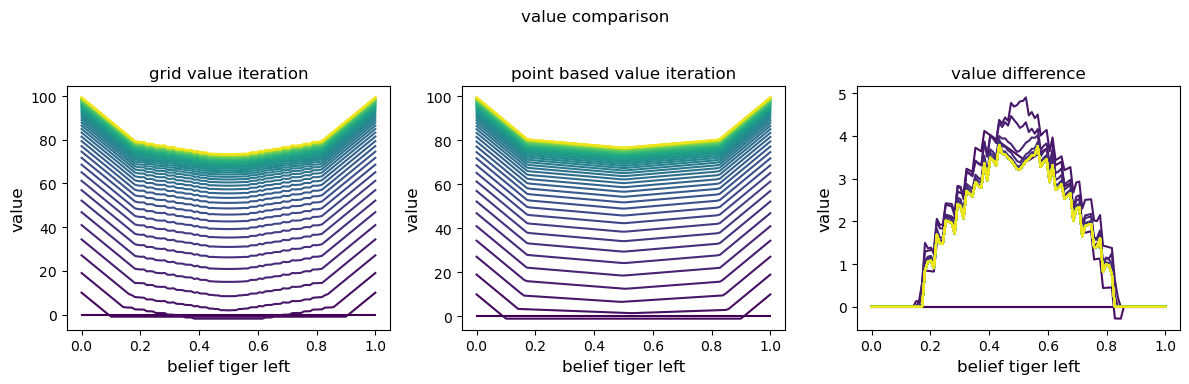

In [8]:
# plot value comparison
cmap = mpl.cm.get_cmap("viridis")
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for t in range(max_iter):
    ax[0].plot(b[:, 0], v_grid[t], c=cmap(t/max_iter))
    ax[1].plot(b[:, 0], v_pb[t], c=cmap(t/max_iter))
    ax[2].plot(b[:, 0], v_pb[t] - v_grid[t], c=cmap(t/max_iter))

ax[0].set_xlabel("belief tiger left")
ax[0].set_ylabel("value")
ax[0].set_title("grid value iteration")

ax[1].set_xlabel("belief tiger left")
ax[1].set_ylabel("value")
ax[1].set_title("point based value iteration")

ax[2].set_xlabel("belief tiger left")
ax[2].set_ylabel("value")
ax[2].set_title("value difference")

plt.suptitle("value comparison")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In the plot above we color the lines by the iteration numbers so that more iterations correspond to brighter colors.

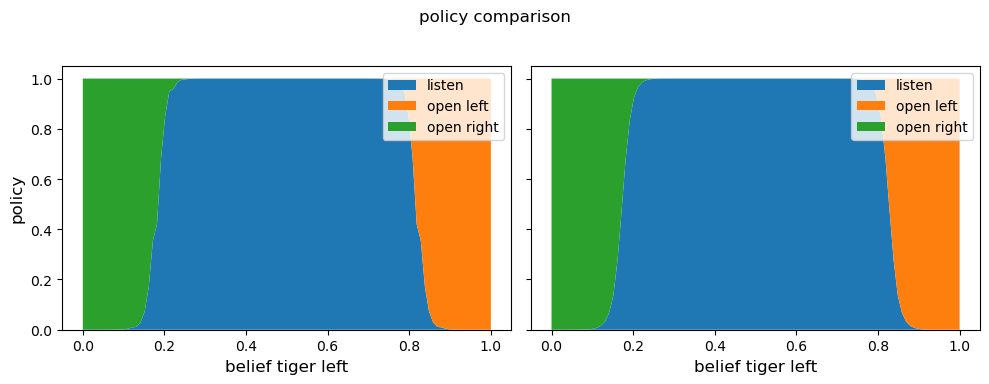

In [9]:
# plot policy comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].stackplot(b[:, 0], pi_grid.T)
ax[0].set_xlabel("belief tiger left")
ax[0].set_ylabel("policy")
ax[0].legend(tiger_env.act_labels)

ax[1].stackplot(b[:, 0], pi_pb.T)
ax[1].set_xlabel("belief tiger left")
ax[1].legend(tiger_env.act_labels)

plt.suptitle("policy comparison")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Conclusion
We see that the computed value functions are similar across iterations. However, they are not exactly the same and the difference is larger when the belief is near $0.5$, i.e., when the decision maker is uncertain about the state. This did not affect the resulting policy much and indeed the resulting policies are similar. This is because when the decision maker is uncertain about where the tiger is it should listen will a high probability.